In [64]:
# !pip install arff
import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import GammaRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_tweedie_deviance,
)
from functools import partial

In [2]:
data_freq = arff.load('/home/jakub/huk/data/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower",
"VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('/home/jakub/huk/data/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

# EDA

In [3]:
df_freq

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
1,3.0,1.0,0.77000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
2,5.0,1.0,0.75000,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22'
3,10.0,1.0,0.09000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
4,11.0,1.0,0.84000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,'E',4.0,0.0,54.0,50.0,'B12',Regular,3317.0,'R93'
678009,6114327.0,0.0,0.00274,'E',4.0,0.0,41.0,95.0,'B12',Regular,9850.0,'R11'
678010,6114328.0,0.0,0.00274,'D',6.0,2.0,45.0,50.0,'B12',Diesel,1323.0,'R82'
678011,6114329.0,0.0,0.00274,'B',4.0,0.0,60.0,50.0,'B12',Regular,95.0,'R26'


In [4]:
df_sev

,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00
...,...,...
26634,3254353.0,1200.00
26635,3254353.0,1800.00
26636,3254353.0,1000.00
26637,2222064.0,767.55


In [5]:
len(df_sev['ClaimAmount'] > 0)

26639

In [6]:
df = pd.merge(df_freq, df_sev, how='left', on='IDpol')
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,1.0,1.0,0.10000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',NaN
1,3.0,1.0,0.77000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',NaN
2,5.0,1.0,0.75000,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22',NaN
3,10.0,1.0,0.09000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',NaN
4,11.0,1.0,0.84000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
679508,6114326.0,0.0,0.00274,'E',4.0,0.0,54.0,50.0,'B12',Regular,3317.0,'R93',NaN
679509,6114327.0,0.0,0.00274,'E',4.0,0.0,41.0,95.0,'B12',Regular,9850.0,'R11',NaN
679510,6114328.0,0.0,0.00274,'D',6.0,2.0,45.0,50.0,'B12',Diesel,1323.0,'R82',NaN
679511,6114329.0,0.0,0.00274,'B',4.0,0.0,60.0,50.0,'B12',Regular,95.0,'R26',NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679513 entries, 0 to 679512
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   IDpol        679513 non-null  float64
 1   ClaimNb      679513 non-null  float64
 2   Exposure     679513 non-null  float64
 3   Area         679513 non-null  object 
 4   VehPower     679513 non-null  float64
 5   VehAge       679513 non-null  float64
 6   DrivAge      679513 non-null  float64
 7   BonusMalus   679513 non-null  float64
 8   VehBrand     679513 non-null  object 
 9   VehGas       679513 non-null  object 
 10  Density      679513 non-null  float64
 11  Region       679513 non-null  object 
 12  ClaimAmount  26444 non-null   float64
dtypes: float64(9), object(4)
memory usage: 67.4+ MB


### First check for missing values

In [8]:
# Check for missing values in the DataFrame
missing_values = df.isnull().sum()

# Display the missing values
print(missing_values)

IDpol               0
ClaimNb             0
Exposure            0
Area                0
VehPower            0
VehAge              0
DrivAge             0
BonusMalus          0
VehBrand            0
VehGas              0
Density             0
Region              0
ClaimAmount    653069
dtype: int64


### Questions:
1. How many rows do we have with 'ClaimNb' > 0 and 'ClaimAmount' NaN?
2. Is there a correlation between drivers age and number of claims or claim amount?
    - same for other variables

### Observations:
1. If during the insurance time there was more than one issue ('ClaimNb' indicates this), we have them as separate rows. This means in order to see the full cost per contract we would need to merge them.

In [9]:
df['ClaimNb'].unique()

array([ 1.,  2.,  4.,  3., 11.,  0.,  5.,  6.,  8., 16.,  9.])

In [10]:
df['ClaimNb'].value_counts()

ClaimNb
0.0     643953
1.0      32178
2.0       3082
3.0        206
11.0        23
4.0         22
16.0        16
5.0         10
9.0          9
8.0          8
6.0          6
Name: count, dtype: int64

In [11]:
def plot_bar(feature, figsize = (9,6)):
    feature_freq = feature.value_counts()
    fig, ax = plt.subplots(figsize = figsize)
    ax.bar(feature_freq.index, feature_freq.values)

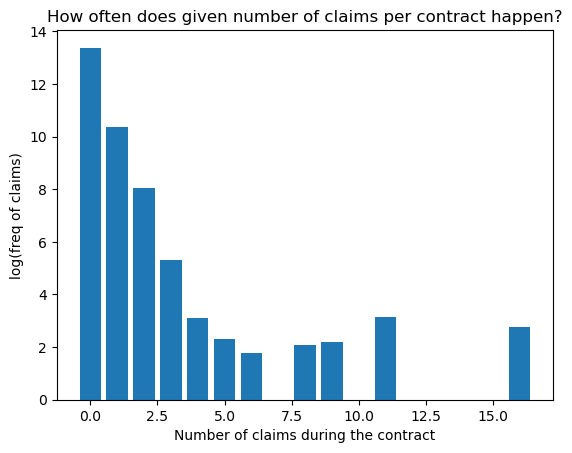

In [12]:
claimNb_freq = df['ClaimNb'].value_counts()
fig, ax = plt.subplots()
ax.bar(claimNb_freq.index, np.log(claimNb_freq.values))
ax.set_ylabel("log(freq of claims)") 
ax.set_xlabel("Number of claims during the contract")
plt.title("How often does given number of claims per contract happen?")
plt.show()

In [13]:
df[df['ClaimAmount'] == 0.0]

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount


### Check Exposure

Max Exposure value is: 2.01


Text(0.5, 1.0, 'Density plot of Exposure')

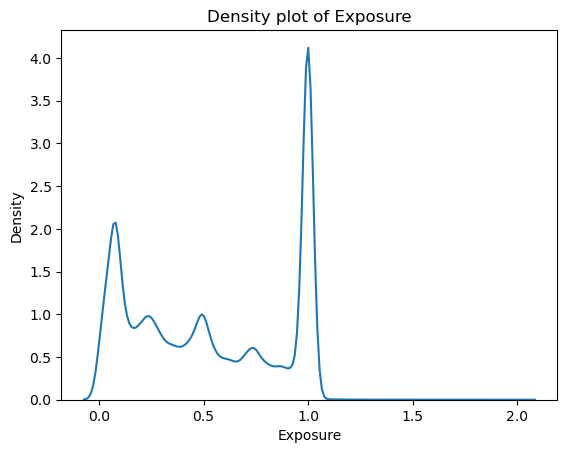

In [14]:
print(f"Max Exposure value is: {np.max(df['Exposure'])}")
sns.kdeplot(df['Exposure'])
plt.title('Density plot of Exposure')

### Area

There are six different Areas: ["'A'" "'B'" "'C'" "'D'" "'E'" "'F'"]


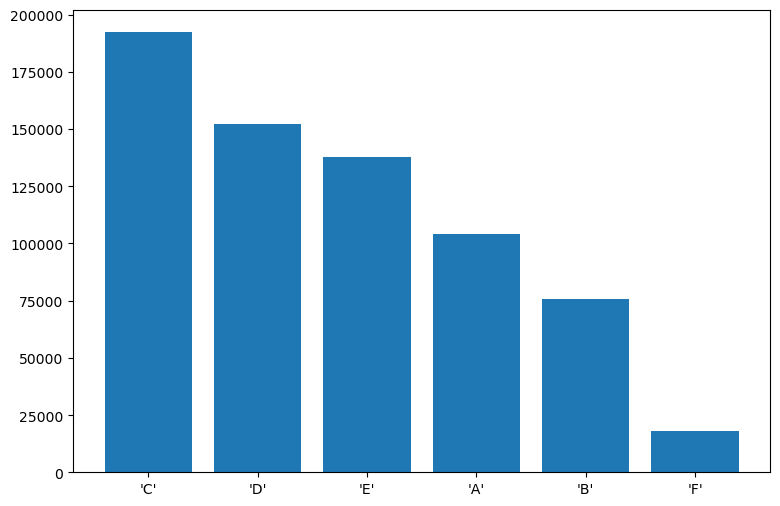

In [15]:
print(f"There are six different Areas: {np.unique(df['Area'])}")
plot_bar(df['Area'])

### Vehicle power

Min value: 4.0, Max value: 15.0


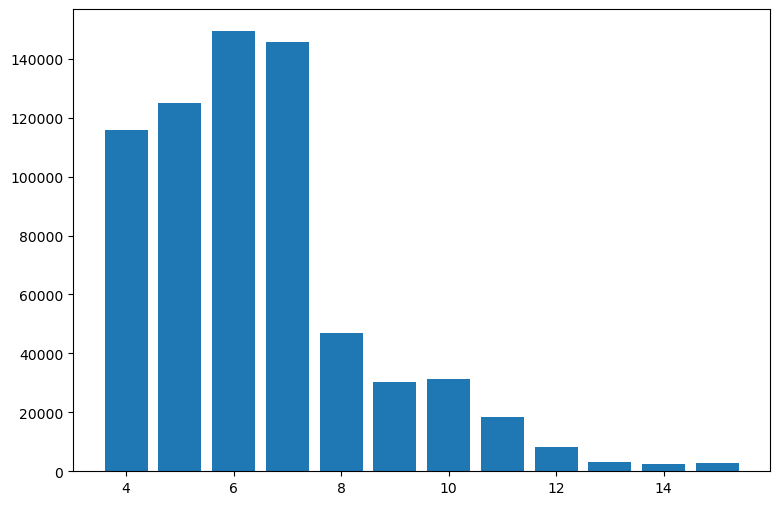

In [16]:
print(f"Min value: {np.min(df['VehPower'])}, Max value: {np.max(df['VehPower'])}")
plot_bar(df['VehPower'])

### Vehicle Age

Min value: 0.0, Max value: 100.0


array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  59.,  60.,  62.,  63.,  64.,  65.,  66.,  68.,  69.,  70.,
        71.,  76.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  99.,
       100.])

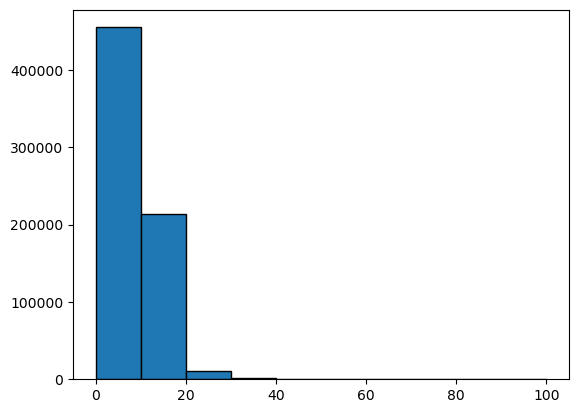

In [17]:
print(f"Min value: {np.min(df['VehAge'])}, Max value: {np.max(df['VehAge'])}")
fig, ax = plt.subplots()
ax.hist(df['VehAge'], bins=10, edgecolor='black')
np.unique(df['VehAge'])

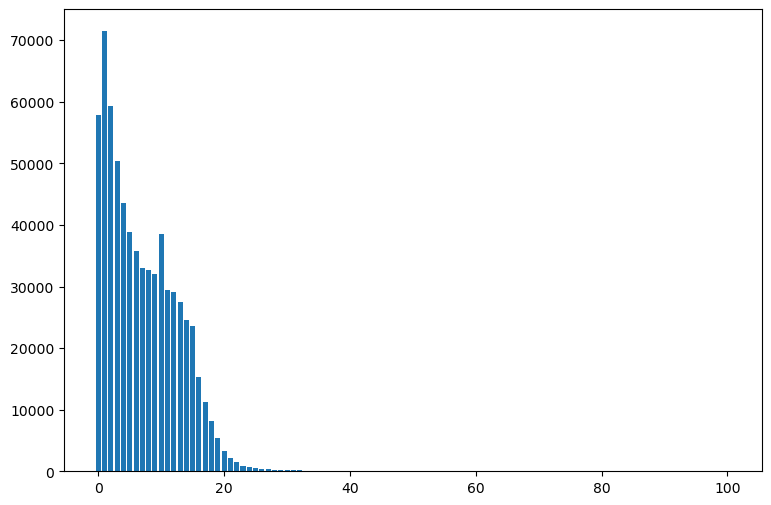

In [18]:
plot_bar(df['VehAge'])

### Driver Age

Min value: 18.0, Max value: 100.0


(array([ 49409., 122158., 137615., 131529., 116821.,  66709.,  36272.,
         16446.,   2274.,    280.]),
 array([ 18. ,  26.2,  34.4,  42.6,  50.8,  59. ,  67.2,  75.4,  83.6,
         91.8, 100. ]),
 <BarContainer object of 10 artists>)

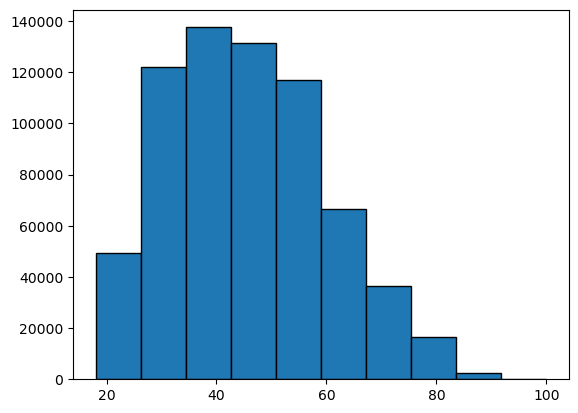

In [19]:
print(f"Min value: {np.min(df['DrivAge'])}, Max value: {np.max(df['DrivAge'])}")
fig, ax = plt.subplots()
ax.hist(df['DrivAge'], bins=10, edgecolor='black')

### Bonus Malus

Min value: 50.0, Max value: 230.0


(array([5.15384e+05, 1.01370e+05, 5.50270e+04, 5.44500e+03, 1.73600e+03,
        4.78000e+02, 3.40000e+01, 2.30000e+01, 1.30000e+01, 3.00000e+00]),
 array([ 50.,  68.,  86., 104., 122., 140., 158., 176., 194., 212., 230.]),
 <BarContainer object of 10 artists>)

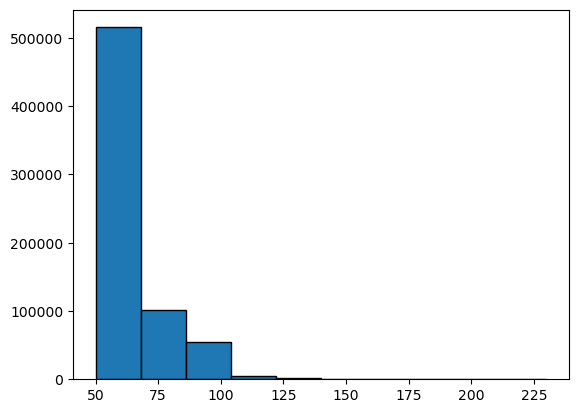

In [20]:
df['BonusMalus']
print(f"Min value: {np.min(df['BonusMalus'])}, Max value: {np.max(df['BonusMalus'])}")
fig, ax = plt.subplots()
ax.hist(df['BonusMalus'], bins=10, edgecolor='black')

### Vehicle Brand

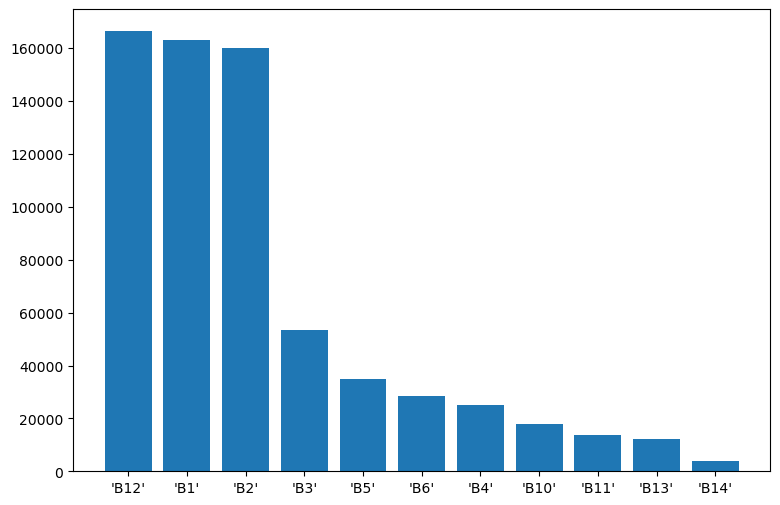

In [21]:
plot_bar(df['VehBrand'])

### Vehicle Gas

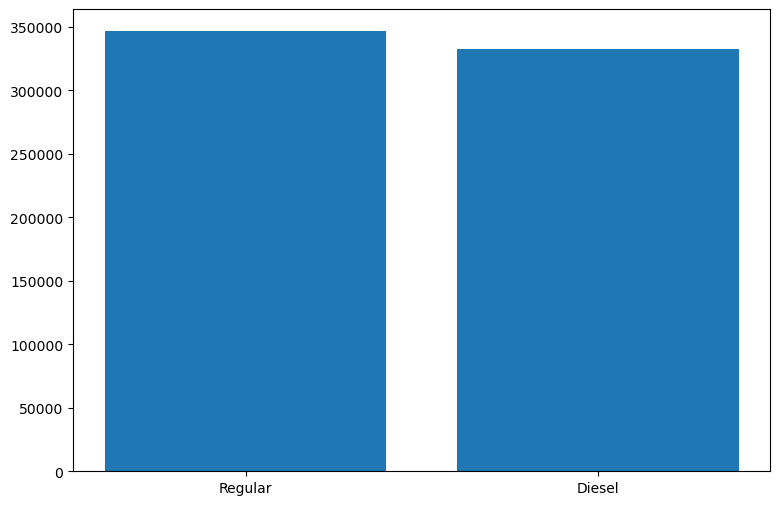

In [22]:
plot_bar(df['VehGas'])

### Area

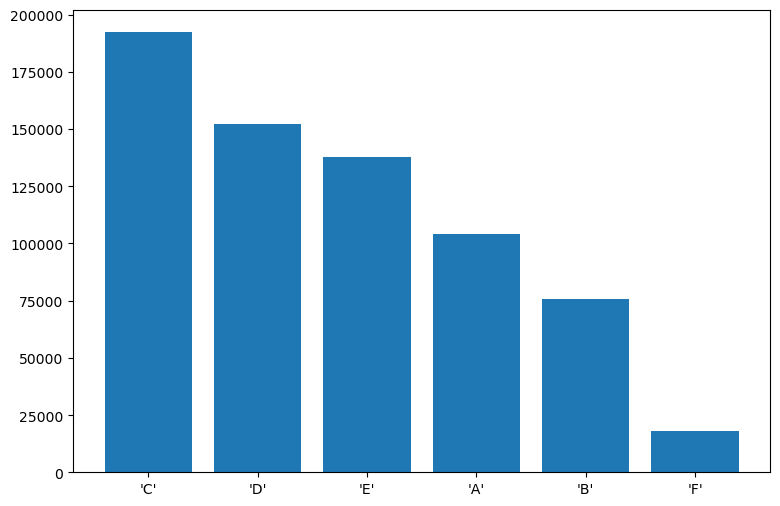

In [23]:
plot_bar(df['Area'])
#  from "A" for rural area to "F" for urban centre

Min value: 1.0, Max value: 27000.0


(array([5.43285e+05, 8.84500e+04, 1.54180e+04, 1.60260e+04, 9.11000e+02,
        1.97700e+03, 2.09700e+03, 8.40000e+01, 7.12000e+02, 1.05530e+04]),
 array([1.00000e+00, 2.70090e+03, 5.40080e+03, 8.10070e+03, 1.08006e+04,
        1.35005e+04, 1.62004e+04, 1.89003e+04, 2.16002e+04, 2.43001e+04,
        2.70000e+04]),
 <BarContainer object of 10 artists>)

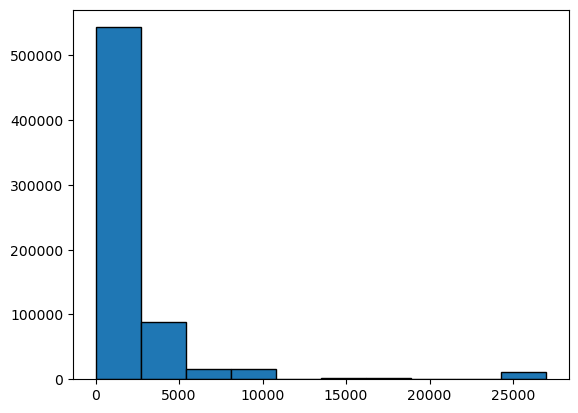

In [24]:
print(f"Min value: {np.min(df['Density'])}, Max value: {np.max(df['Density'])}")
fig, ax = plt.subplots()
ax.hist(df['Density'], bins=10, edgecolor='black')

### Region

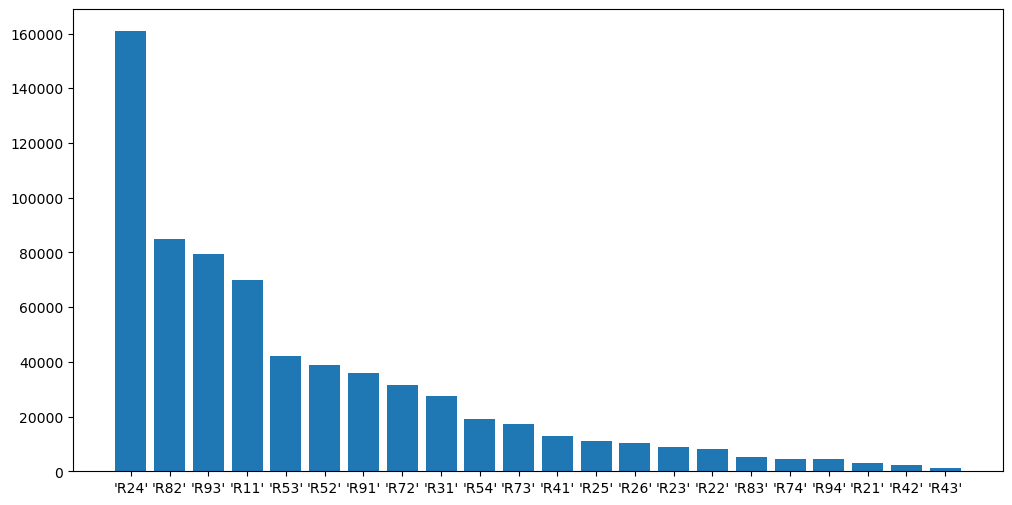

In [25]:
plot_bar(df['Region'], figsize=(12,6))

### Claim Amount

Max ClaimAmount Calue is: 4075400.56


Text(0.5, 1.0, 'Density plot of ClaimAmount')

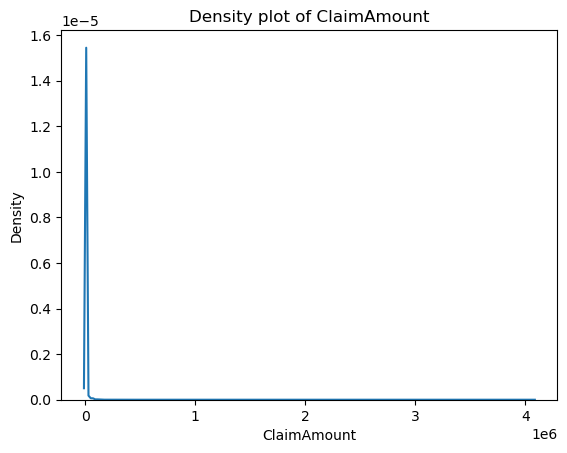

In [26]:
print(f"Max ClaimAmount Calue is: {np.max(df['ClaimAmount'])}")
sns.kdeplot(df['ClaimAmount'][df['ClaimAmount'] > 0])
plt.title('Density plot of ClaimAmount')

In [27]:
df['ClaimAmount'][df['ClaimAmount'] > 0]

66          303.00
93         1981.84
199        1456.55
205         989.64
206        9844.36
            ...   
678974     1769.88
678998     1288.28
679015    10290.00
679016     1940.40
679153     1452.00
Name: ClaimAmount, Length: 26444, dtype: float64

In [28]:
## So now I want to 

In [29]:
df[df['IDpol'] == 3254353.0]

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
489350,3254353.0,11.0,0.07,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',85.51
489351,3254353.0,11.0,0.07,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',3000.00
489352,3254353.0,11.0,0.07,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',4802.27
489353,3254353.0,11.0,0.07,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',1800.00
489354,3254353.0,11.0,0.07,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',200.00
489355,3254353.0,11.0,0.07,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',1500.00
489356,3254353.0,11.0,0.07,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',1000.00
489357,3254353.0,11.0,0.07,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',1200.00
489358,3254353.0,11.0,0.07,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',1200.00
489359,3254353.0,11.0,0.07,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',1800.00


In [30]:
print(len(df[df['ClaimNb'] == 16]))
df[df['ClaimNb'] == 16]

16


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
321988,2241683.0,16.0,0.33,'D',4.0,12.0,52.0,50.0,'B1',Regular,824.0,'R91',809.31
321989,2241683.0,16.0,0.33,'D',4.0,12.0,52.0,50.0,'B1',Regular,824.0,'R91',4500.00
321990,2241683.0,16.0,0.33,'D',4.0,12.0,52.0,50.0,'B1',Regular,824.0,'R91',1628.50
321991,2241683.0,16.0,0.33,'D',4.0,12.0,52.0,50.0,'B1',Regular,824.0,'R91',1987.42
321992,2241683.0,16.0,0.33,'D',4.0,12.0,52.0,50.0,'B1',Regular,824.0,'R91',1520.00
321993,2241683.0,16.0,0.33,'D',4.0,12.0,52.0,50.0,'B1',Regular,824.0,'R91',101.66
321994,2241683.0,16.0,0.33,'D',4.0,12.0,52.0,50.0,'B1',Regular,824.0,'R91',127.74
321995,2241683.0,16.0,0.33,'D',4.0,12.0,52.0,50.0,'B1',Regular,824.0,'R91',2093.85
321996,2241683.0,16.0,0.33,'D',4.0,12.0,52.0,50.0,'B1',Regular,824.0,'R91',1500.00
321997,2241683.0,16.0,0.33,'D',4.0,12.0,52.0,50.0,'B1',Regular,824.0,'R91',1965.60


In [31]:
print(len(df[df['ClaimNb'] == 11]))
df[df['ClaimNb'] == 11]

23


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
6550,19471.0,11.0,1.00,'A',5.0,6.0,65.0,50.0,'B2',Diesel,13.0,'R24',NaN
488337,3253234.0,11.0,0.08,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',8000.00
488338,3253234.0,11.0,0.08,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',5000.00
488339,3253234.0,11.0,0.08,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',1739.82
488340,3253234.0,11.0,0.08,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',1700.00
488341,3253234.0,11.0,0.08,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',1760.00
488342,3253234.0,11.0,0.08,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',1500.00
488343,3253234.0,11.0,0.08,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',742.86
488344,3253234.0,11.0,0.08,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',1500.00
488345,3253234.0,11.0,0.08,'D',4.0,13.0,53.0,50.0,'B1',Regular,824.0,'R91',1500.00


### Checking if there are cases where some claims are NaN and some available

In [32]:
df_ca_nans = df[(df['ClaimNb'] > 0) & (df['ClaimAmount'].isnull())]
df_ca_nans

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,1.0,1.0,0.10,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',NaN
1,3.0,1.0,0.77,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',NaN
2,5.0,1.0,0.75,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22',NaN
3,10.0,1.0,0.09,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',NaN
4,11.0,1.0,0.84,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
534825,4124801.0,1.0,1.00,'C',5.0,5.0,45.0,50.0,'B5',Regular,242.0,'R82',NaN
536553,4126524.0,1.0,1.00,'D',5.0,6.0,43.0,54.0,'B2',Regular,1282.0,'R31',NaN
546624,4136585.0,1.0,1.00,'C',6.0,12.0,44.0,50.0,'B1',Diesel,304.0,'R11',NaN
596598,4186466.0,1.0,0.59,'D',10.0,10.0,63.0,50.0,'B13',Regular,1313.0,'R24',NaN


In [33]:
df_sev[(df_sev['IDpol'].isin(df_ca_nans['IDpol']))]

,IDpol,ClaimAmount


So either we have the Claim Amount for all Claims for the given contract or for none. There is no situation where we have claim amount for some claims and for some not. Hence we can safely merge them.

I will remove all the rows where ClaimNb > 0.0 and ClaimAmount == NaN. We could try to impute these values. But this could be in the scope of the deeper analysis. For now we wanna focus on other parts.

In [34]:
df1 = df[~df['IDpol'].isin(df_ca_nans['IDpol'])]
df1

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
66,139.0,1.0,0.75000,'F',7.0,1.0,61.0,50.0,'B12',Regular,27000.0,'R11',303.00
93,190.0,1.0,0.14000,'B',12.0,5.0,50.0,60.0,'B12',Diesel,56.0,'R25',1981.84
199,414.0,1.0,0.14000,'E',4.0,0.0,36.0,85.0,'B12',Regular,4792.0,'R11',1456.55
205,424.0,2.0,0.62000,'F',10.0,0.0,51.0,100.0,'B12',Regular,27000.0,'R11',989.64
206,424.0,2.0,0.62000,'F',10.0,0.0,51.0,100.0,'B12',Regular,27000.0,'R11',9844.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
679508,6114326.0,0.0,0.00274,'E',4.0,0.0,54.0,50.0,'B12',Regular,3317.0,'R93',NaN
679509,6114327.0,0.0,0.00274,'E',4.0,0.0,41.0,95.0,'B12',Regular,9850.0,'R11',NaN
679510,6114328.0,0.0,0.00274,'D',6.0,2.0,45.0,50.0,'B12',Diesel,1323.0,'R82',NaN
679511,6114329.0,0.0,0.00274,'B',4.0,0.0,60.0,50.0,'B12',Regular,95.0,'R26',NaN


In [35]:
df1[(df1['ClaimNb'] > 0) & (df1['ClaimAmount'].isnull())]

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount


### Now I want to add all the separate claims from a given contract together.

In [36]:
# Group by 'IDpol' and sum the 'ClaimAmount'
df_sum = df1.groupby('IDpol', as_index=False)['ClaimAmount'].sum()

# Merge the summed DataFrame back to the original DataFrame to remove original rows
df1 = df1.drop(columns=['ClaimAmount']).drop_duplicates().merge(df_sum, on='IDpol')

# Display the resulting DataFrame
df1

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,139.0,1.0,0.75000,'F',7.0,1.0,61.0,50.0,'B12',Regular,27000.0,'R11',303.00
1,190.0,1.0,0.14000,'B',12.0,5.0,50.0,60.0,'B12',Diesel,56.0,'R25',1981.84
2,414.0,1.0,0.14000,'E',4.0,0.0,36.0,85.0,'B12',Regular,4792.0,'R11',1456.55
3,424.0,2.0,0.62000,'F',10.0,0.0,51.0,100.0,'B12',Regular,27000.0,'R11',10834.00
4,463.0,1.0,0.31000,'A',5.0,0.0,45.0,50.0,'B12',Regular,12.0,'R73',3986.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
668892,6114326.0,0.0,0.00274,'E',4.0,0.0,54.0,50.0,'B12',Regular,3317.0,'R93',0.00
668893,6114327.0,0.0,0.00274,'E',4.0,0.0,41.0,95.0,'B12',Regular,9850.0,'R11',0.00
668894,6114328.0,0.0,0.00274,'D',6.0,2.0,45.0,50.0,'B12',Diesel,1323.0,'R82',0.00
668895,6114329.0,0.0,0.00274,'B',4.0,0.0,60.0,50.0,'B12',Regular,95.0,'R26',0.00


In [37]:
df1[df1['ClaimAmount'] > 0.0]

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,139.0,1.0,0.75,'F',7.0,1.0,61.0,50.0,'B12',Regular,27000.0,'R11',303.00
1,190.0,1.0,0.14,'B',12.0,5.0,50.0,60.0,'B12',Diesel,56.0,'R25',1981.84
2,414.0,1.0,0.14,'E',4.0,0.0,36.0,85.0,'B12',Regular,4792.0,'R11',1456.55
3,424.0,2.0,0.62,'F',10.0,0.0,51.0,100.0,'B12',Regular,27000.0,'R11',10834.00
4,463.0,1.0,0.31,'A',5.0,0.0,45.0,50.0,'B12',Regular,12.0,'R73',3986.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
668087,6113521.0,1.0,0.18,'C',4.0,1.0,26.0,60.0,'B12',Diesel,311.0,'R82',1324.40
668359,6113793.0,1.0,0.14,'C',7.0,2.0,51.0,50.0,'B12',Diesel,178.0,'R72',1769.88
668383,6113817.0,1.0,0.17,'D',4.0,0.0,35.0,51.0,'B12',Regular,1719.0,'R82',1288.28
668400,6113834.0,2.0,0.17,'C',15.0,3.0,36.0,50.0,'B12',Regular,181.0,'R54',12230.40


### Now I want to create our target variable ClaimAmount/Exposure -> Pure Premium

In [60]:
df1['PurePremium'] = df1['ClaimAmount']/df1['Exposure']

# ure premium can be lso indirectly approximated by a 2-step modeling: the product of the
# Freqency times the averge claim amount per claim:
df1["Frequency"] = df1["ClaimNb"] / df1["Exposure"]
df1["AvgClaimAmount"] = df1["ClaimAmount"] / np.fmax(df1["ClaimNb"], 1)

df1

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
0,139.0,1.0,0.75000,F,7.0,1.0,61.0,50.0,B12,Regular,27000.0,R11,303.00,404.000000,1.333333,303.00
1,190.0,1.0,0.14000,B,12.0,5.0,50.0,60.0,B12,Diesel,56.0,R25,1981.84,14156.000000,7.142857,1981.84
2,414.0,1.0,0.14000,E,4.0,0.0,36.0,85.0,B12,Regular,4792.0,R11,1456.55,10403.928571,7.142857,1456.55
3,424.0,2.0,0.62000,F,10.0,0.0,51.0,100.0,B12,Regular,27000.0,R11,10834.00,17474.193548,3.225806,5417.00
4,463.0,1.0,0.31000,A,5.0,0.0,45.0,50.0,B12,Regular,12.0,R73,3986.67,12860.225806,3.225806,3986.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668892,6114326.0,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93,0.00,0.000000,0.000000,0.00
668893,6114327.0,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11,0.00,0.000000,0.000000,0.00
668894,6114328.0,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82,0.00,0.000000,0.000000,0.00
668895,6114329.0,0.0,0.00274,B,4.0,0.0,60.0,50.0,B12,Regular,95.0,R26,0.00,0.000000,0.000000,0.00


### Now we can check the correlation of predictors and our target variable.

<Axes: >

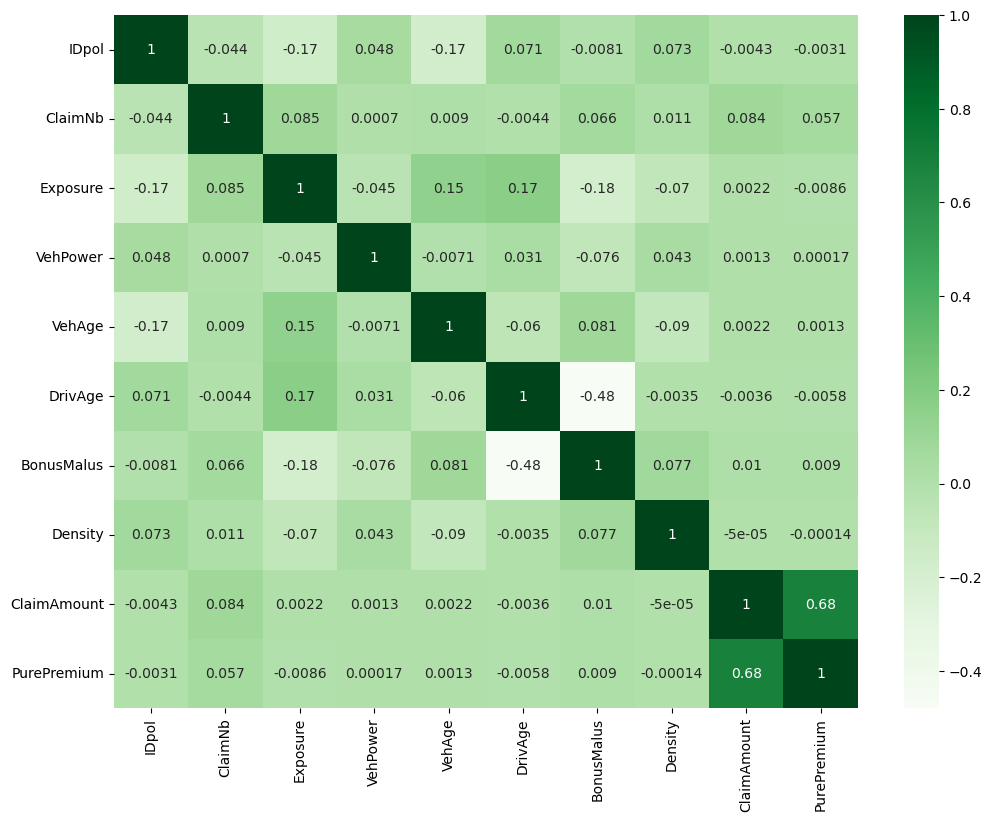

In [39]:
corr_mat = df1.select_dtypes(include='float').corr()

# plotting correlation matrix
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr_mat, cmap="Greens", annot=True)

### Based on correlation matrix:
1. Drivers age has very weak negative correlation both with number of claims, claim amount and pure premium. However it could be good to bin age into certain age groups.
2. Well basically we do not learn anything suprising from this matrix. Relations are in general weak.

### Plot relations among some target and independent variables.

In [40]:
def plot_scatter(x,y,figsize = (9,6), log_y: bool = False):
    fig, ax = plt.subplots(figsize = figsize)
    if log_y:
        ax.scatter(x,np.log(y))    
    else:
        ax.scatter(x,y)

/home/jakub/conda/envs/huk_cc/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


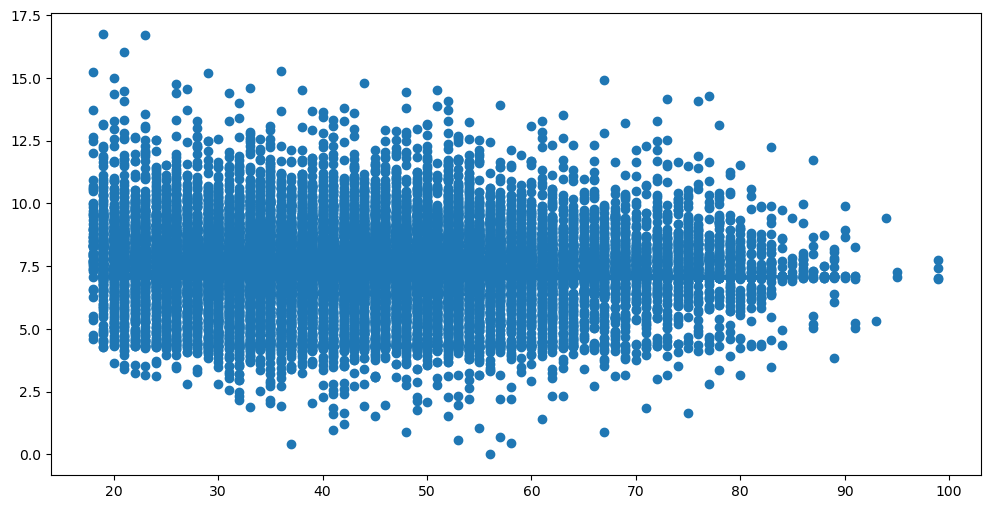

In [41]:
fig, ax = plt.subplots(figsize = (12,6))
ax.scatter(df1['DrivAge'], np.log(df1['PurePremium']))

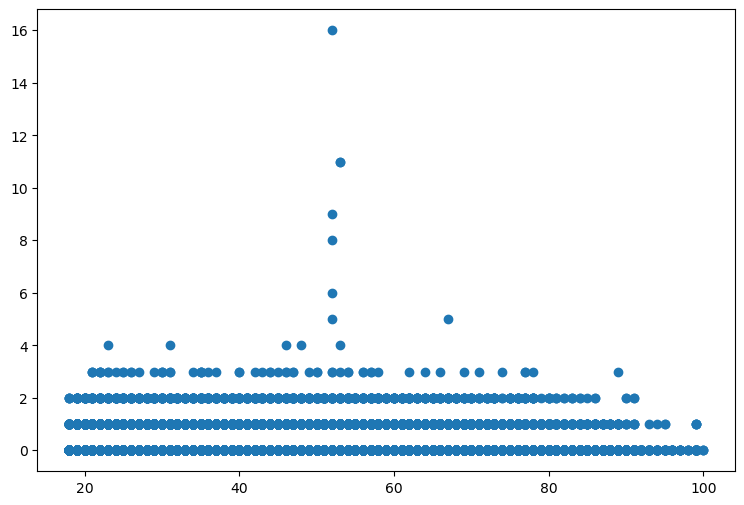

In [42]:
plot_scatter(df1['DrivAge'], df1['ClaimNb'])

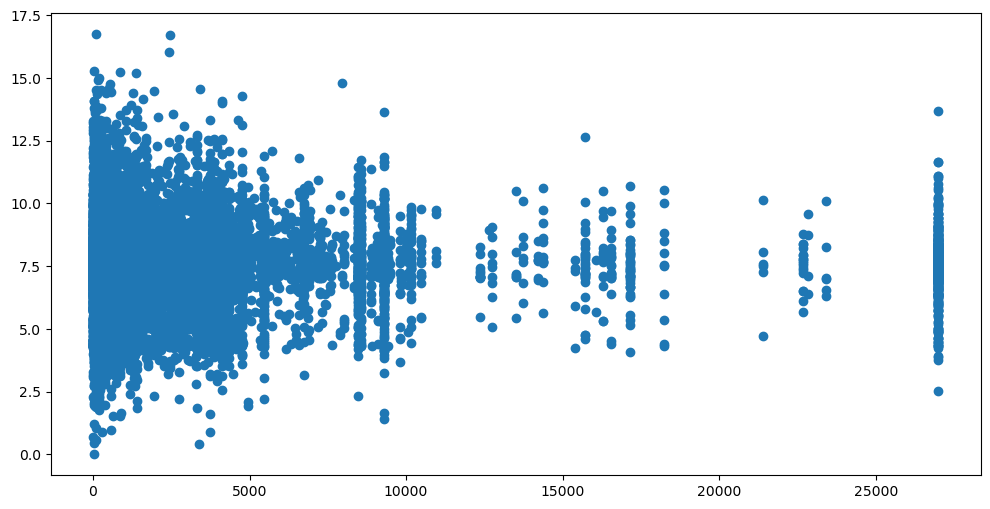

In [43]:
plot_scatter(df1['Density'], df1['PurePremium'], figsize=(12,6), log_y=True)

# Feature Engineering
### Preprocess the data

In [44]:
# unquote string fields
def unquote_string_fields(df):
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df

In [45]:
log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log), StandardScaler()
)

column_trans = ColumnTransformer(
    [
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, random_state=0),
            ["VehAge", "DrivAge"],
        ),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
    ],
    remainder="drop",
)

In [46]:
df1 = unquote_string_fields(df1)
X = column_trans.fit_transform(df1)
y = df1['PurePremium']
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6020073 stored elements and shape (668897, 75)>

It would make sense here to account for umbalancedness?

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# # Define the models
# clfs = [
#     LinearRegression(),
#     DecisionTreeRegressor(),
#     RandomForestRegressor(max_depth=10, random_state=0),
#     SVR()
# ]

# # Create the pipelines
# # pipelines = [Pipeline(steps=[('preprocessor', column_trans), ('clf', clf)]) for clf in clfs]

# # Placeholder for results
# results = {}

# Perform 5-fold cross-validation for each model
# for clf in clfs:
#     pipeline = Pipeline(steps=[('preprocessor', column_trans),
#         ('model', clf)
#     ])
#     scores = cross_val_score(pipeline, df1, y, cv=5, scoring='neg_mean_squared_error')
#     results[clf.__class__.__name__] = np.mean(scores)

# # Print the results
# for model_name, score in results.items():
#     print(f"{model_name}: {score}")

# Model Comparison

In [48]:
forest = RandomForestRegressor(max_depth=10, random_state=0).fit(X_train, y_train)
print(f"RandomForestRegressor score: {forest.score(X_test, y_test)}")

RandomForestClassifier score: -0.29671780704350126


This means that our RandomForestRegressor is worse than simply predicting the mean value.

In [54]:
# Convert sparse matrices to dense arrays
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Fit the model
clf = HistGradientBoostingRegressor(max_iter=100).fit(X_train_dense, y_train)

# Print the score
print(f"HistGradientBoostingRegressor score: {clf.score(X_test_dense, y_test)}")

HistGradientBoostingRegressor score: -0.01292123709504267


HistGradientBoostingRegressor still performs worse than predicting the mean value.

In [57]:
# Define a transformer to convert sparse matrices to dense
to_dense = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)

# Define the models
clfs = [
    HistGradientBoostingRegressor(max_iter=100)
]

# Create the pipelines
pipelines = [Pipeline(steps=[('preprocessor', column_trans), ('clf', clf)]) for clf in clfs]

# Placeholder for results
results = {}

# Perform 5-fold cross-validation for each model
for clf in clfs:
    pipeline = Pipeline(steps=[('preprocessor', column_trans),
                               ('to_dense', to_dense),
        ('model', clf)
    ])
    scores = cross_val_score(pipeline, df1, y, cv=5, scoring='r2')
    results[clf.__class__.__name__] = np.mean(scores)

# Print the results
for model_name, score in results.items():
    print(f"{model_name}: {score}")

HistGradientBoostingRegressor: -0.030835859004014886


This is also confirmed using 5-fold CV.

# GLM models for frequency and average claim amount

In [65]:
def score_estimator(
    estimator,
    X_train,
    X_test,
    df_train,
    df_test,
    target,
    weights,
    tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),  # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [
            (
                "mean Tweedie dev p={:.4f}".format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append({"subset": subset_label, "metric": score_label, "score": score})

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ["train", "test"]]
    )
    return res

In [67]:
X = column_trans.fit_transform(df1)
df_train, df_test, X_train, X_test = train_test_split(df1, X, random_state=0)

In [68]:
glm_freq = PoissonRegressor(alpha=1e-4, solver="newton-cholesky")
glm_freq.fit(X_train, df_train["Frequency"], sample_weight=df_train["Exposure"])

PoissonRegressor(alpha=0.0001, solver='newton-cholesky')

In [69]:
scores = score_estimator(
    glm_freq,
    X_train,
    X_test,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)
print("Evaluation of PoissonRegressor on target Frequency")
print(scores)

Evaluation of PoissonRegressor on target Frequency
subset               train    test
metric                            
D² explained        0.0443  0.0415
mean abs. error     0.1398  0.1397
mean squared error  0.2593  0.2435


In [70]:
mask_train = df_train["ClaimAmount"] > 0
mask_test = df_test["ClaimAmount"] > 0

glm_sev = GammaRegressor(alpha=10.0, solver="newton-cholesky")

glm_sev.fit(
    X_train[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

scores = score_estimator(
    glm_sev,
    X_train[mask_train.values],
    X_test[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)
print("Evaluation of GammaRegressor on target AvgClaimAmount")
print(scores)

Evaluation of GammaRegressor on target AvgClaimAmount
subset                     train          test
metric                                        
D² explained        1.980000e-02  2.010000e-02
mean abs. error     1.998241e+03  2.590829e+03
mean squared error  2.188979e+08  2.620911e+09


### For comparison model that predicts average:

In [73]:
dummy_sev = DummyRegressor(strategy="mean")
dummy_sev.fit(
    X_train[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

scores = score_estimator(
    dummy_sev,
    X_train[mask_train.values],
    X_test[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)
print("Evaluation of a mean predictor on target AvgClaimAmount")
print(scores)

Evaluation of a mean predictor on target AvgClaimAmount
subset                     train          test
metric                                        
D² explained        0.000000e+00 -1.000000e-04
mean abs. error     1.992284e+03  2.586503e+03
mean squared error  2.190391e+08  2.621560e+09


In [74]:
print(
    "Mean AvgClaim Amount per policy:              %.2f "
    % df_train["AvgClaimAmount"].mean()
)
print(
    "Mean AvgClaim Amount | NbClaim > 0:           %.2f"
    % df_train["AvgClaimAmount"][df_train["AvgClaimAmount"] > 0].mean()
)
print(
    "Predicted Mean AvgClaim Amount | NbClaim > 0: %.2f"
    % glm_sev.predict(X_train).mean()
)
print(
    "Predicted Mean AvgClaim Amount (dummy) | NbClaim > 0: %.2f"
    % dummy_sev.predict(X_train).mean()
)

Mean AvgClaim Amount per policy:              77.10 
Mean AvgClaim Amount | NbClaim > 0:           2068.40
Predicted Mean AvgClaim Amount | NbClaim > 0: 2013.37
Predicted Mean AvgClaim Amount (dummy) | NbClaim > 0: 2118.51


In [76]:
scores_product_model = score_estimator(
    (glm_freq, glm_sev),
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
)
scores_product_model

subset,train,test
metric,,
mean abs. error,2.959301e+02,3.397747e+02
mean squared error,7.975437e+07,8.866186e+08


Comparing observed and predicted total claim amount over the test and train subsets. On average, our model tends to underestimate the total claim on the test set (but this behavior depends on the amount of regularization).

In [77]:
res = []
for subset_label, X, df in [
    ("train", X_train, df_train),
    ("test", X_test, df_test),
]:
    exposure = df["Exposure"].values
    res.append(
        {
            "subset": subset_label,
            "observed": df["ClaimAmount"].values.sum(),
            "predicted, frequency*severity model": np.sum(
                exposure * glm_freq.predict(X) * glm_sev.predict(X)
            ),
        }
    )

print(pd.DataFrame(res).set_index("subset").T)

subset                                      train          test
observed                             4.210756e+07  1.780166e+07
predicted, frequency*severity model  4.213132e+07  1.408202e+07
